# ***1. Importación de librerías y datos***

In [41]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Cargar los conjuntos de datos
datanum = pd.read_csv("../Data/numeric_data.csv")
datatree = pd.read_csv("../Data/data_tree.csv")

In [27]:
# Visualizamos información sobre los datos
print("Datos numéricos:")
datanum.info()

Datos numéricos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Age                                                   2556 non-null   float64
 1   Work/Study Hours                                      2556 non-null   float64
 2   Depression                                            2556 non-null   int64  
 3   Working Professional or Student_Working Professional  2556 non-null   int64  
 4   Have you ever had suicidal thoughts ?_Yes             2556 non-null   int64  
 5   Dietary Habits_Healthy                                2556 non-null   int64  
 6   Dietary Habits_Moderate                               2556 non-null   int64  
 7   Dietary Habits_Unhealthy                              2556 non-null   int64  
 8   Degree_B.Arch                            

In [28]:
# Visualizamos información sobre los datos
print("Datos categóricos:")
datatree.sample(5)

Datos categóricos:


,Age,Work/Study Hours,Depression,Working Professional or Student_Working Professional,Have you ever had suicidal thoughts ?_Yes,Dietary Habits_Healthy,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Degree_B.Arch,Degree_B.Com,...,Job/Study Satisfaction_1.0,Job/Study Satisfaction_2.0,Job/Study Satisfaction_3.0,Job/Study Satisfaction_4.0,Job/Study Satisfaction_5.0,Work/Academic Pressure_1.0,Work/Academic Pressure_2.0,Work/Academic Pressure_3.0,Work/Academic Pressure_4.0,Work/Academic Pressure_5.0
1102,45,10,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1685,42,5,0,1,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1555,21,2,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2018,28,6,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2328,21,10,0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [29]:
# Función para división de datos
from sklearn.model_selection import train_test_split

def dividir_datos(dataset, target_column):
    # División de los datos en entrenamiento y prueba
    X = dataset.drop(target_column, axis=1)
    Y = dataset[target_column]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
    
    return X_train, X_test, Y_train, Y_test

In [31]:
# Función para balancear datos numéricos con SMOTE
from imblearn.over_sampling import SMOTE

def balanceo(X_train, Y_train):
    # Aplicar SMOTE al conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_bal, Y_train_bal = smote.fit_resample(X_train, Y_train)

    Y_train_bal.value_counts().plot(kind='barh')
    
    return X_train_bal, Y_train_bal

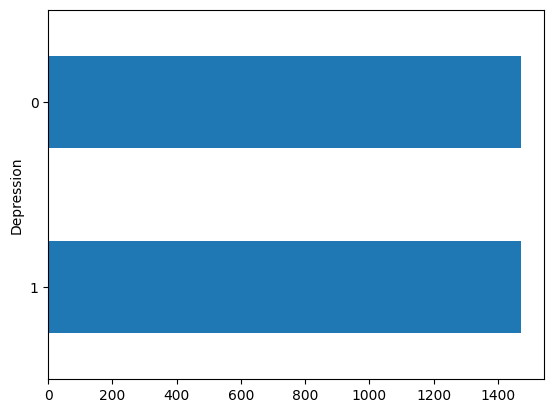

In [32]:
# Dividir y balancear los conjuntos de datos numéricos
X_num_train, X_num_test, Y_num_train, Y_num_test = dividir_datos(datanum, 'Depression')
X_num_train_bal, Y_num_train_bal = balanceo(X_num_train, Y_num_train)

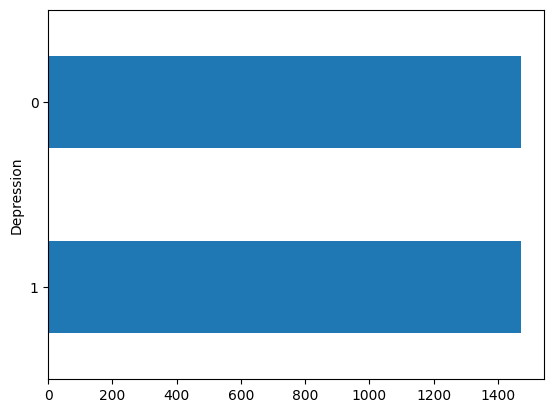

In [33]:
# Dividir y balancear los conjuntos de datos categóricos
X_tree_train, X_tree_test, Y_tree_train, Y_tree_test = dividir_datos(datatree, 'Depression')
X_tree_train_bal, Y_tree_train_bal = balanceo(X_tree_train, Y_tree_train)

In [ ]:
#Librerías para clasificación
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Graphics
import seaborn as sns

## ***MACHINE LEARNING METHODS***

In [56]:
# Lista de modelos
models = {
    "Support Vector Classifier": SVC(kernel='linear', random_state=42),
    "Artificial Neural Network": MLPClassifier(activation="relu", hidden_layer_sizes=(26), learning_rate='constant', learning_rate_init=0.02, momentum= 0.3, max_iter=500, verbose=False, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', min_samples_leaf=20, max_depth=2, random_state=42)
}

In [70]:
# Configuración de validación cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Función para realizar validación cruzada con cross_validate y múltiples métricas
def crossValidateModels(models, X, y, cv):
    results = {}
    for model_name, model in models.items():
        # Evaluar el modelo con cross_validate usando varias métricas
        scores = cross_validate(
            model, X, y, cv=cv, 
            scoring={'accuracy': 'accuracy', 
                     'precision': 'precision_weighted', 
                     'recall': 'recall_weighted', 
                     'f1': 'f1_weighted'}, 
            return_train_score=True
        )
        
        # Guardar las métricas en el diccionario de resultados
        results[model_name] = {
            "Train Accuracy Mean": scores['train_accuracy'].mean(),
            "Test Accuracy Mean": scores['test_accuracy'].mean(),
            "Train Precision Mean": scores['train_precision'].mean(),
            "Test Precision Mean": scores['test_precision'].mean(),
            "Train Recall Mean": scores['train_recall'].mean(),
            "Test Recall Mean": scores['test_recall'].mean(),
            "Train F1 Mean": scores['train_f1'].mean(),
            "Test F1 Mean": scores['test_f1'].mean(),
            "Fit Time Mean": scores['fit_time'].mean(),
            "Score Time Mean": scores['score_time'].mean()
        }

        # Imprimir las métricas
        print(f"Modelo: {model_name}")
        print(f"   - Fit Time Mean: {scores['fit_time'].mean():.4f} seconds")
        print(f"   - Score Time Mean: {scores['score_time'].mean():.4f} seconds\n")
    
    return results


In [71]:
metrics = crossValidateModels(models, X_num_train_bal, Y_num_train_bal, cv)

Modelo: Support Vector Classifier
   - Fit Time Mean: 0.0606 seconds
   - Score Time Mean: 0.0132 seconds

Modelo: Artificial Neural Network
   - Fit Time Mean: 0.7336 seconds
   - Score Time Mean: 0.0113 seconds

Modelo: K-Nearest Neighbors
   - Fit Time Mean: 0.0095 seconds
   - Score Time Mean: 0.0580 seconds

Modelo: Logistic Regression
   - Fit Time Mean: 0.0191 seconds
   - Score Time Mean: 0.0146 seconds

Modelo: Decision Tree
   - Fit Time Mean: 0.0138 seconds
   - Score Time Mean: 0.0157 seconds



In [72]:
pd.DataFrame(metrics)

,Support Vector Classifier,Artificial Neural Network,K-Nearest Neighbors,Logistic Regression,Decision Tree
Train Accuracy Mean,0.981003,1.000000,0.925901,0.981079,0.833938
Test Accuracy Mean,0.974506,0.970430,0.866413,0.975191,0.828010
Train Precision Mean,0.981040,1.000000,0.935055,0.981092,0.834647
Test Precision Mean,0.974901,0.970787,0.893380,0.975587,0.830570
Train Recall Mean,0.981003,1.000000,0.925901,0.981079,0.833938
Test Recall Mean,0.974506,0.970430,0.866413,0.975191,0.828010
Train F1 Mean,0.981003,1.000000,0.925508,0.981078,0.833837
Test F1 Mean,0.974500,0.970424,0.863965,0.975185,0.827628
Fit Time Mean,0.060598,0.733614,0.009531,0.019101,0.013830
Score Time Mean,0.013247,0.011312,0.058026,0.014586,0.015746


In [75]:
# Función para entrenar todos los modelos en el diccionario
def train_models(models, X_train, y_train):
    # Diccionario para almacenar los modelos entrenados
    trained_models = {}
    
    # Entrenar cada modelo en el diccionario
    for model_name, model in models.items():
        print(f"Training model: {model_name}")
        model.fit(X_train, y_train)
        trained_models[model_name] = model  # Guardar el modelo entrenado
    
    return trained_models

In [76]:
trained = train_models(models, X_num_train_bal, Y_num_train_bal)

Training model: Support Vector Classifier
Training model: Artificial Neural Network
Training model: K-Nearest Neighbors
Training model: Logistic Regression
Training model: Decision Tree


In [80]:
# Función para evaluar el modelo entrenado
def evaluate_model(model, X_test, y_test, model_name):
    # Realizar predicciones
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Graficar matriz de confusión
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Graficar curva ROC
    if hasattr(model, "predict_proba"):  # Verifica si el modelo soporta predict_proba
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    else:
        roc_auc = None
    
    # Retornar métricas en un diccionario
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc
    }


In [81]:
def metrics(models, X_test, y_test):
    # Crear un DataFrame vacío con las métricas como índice
    metrics_df = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
    
    for model_name, model in models.items():
        # Evaluar el modelo y obtener métricas
        metrics = evaluate_model(model, X_test, y_test, model_name)
        
        # Agregar los resultados al DataFrame
        metrics_df[model_name] = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1'], metrics['auc']]
    
    return metrics_df

Training model: Support Vector Classifier
Training model: Artificial Neural Network
Training model: K-Nearest Neighbors
Training model: Logistic Regression
Training model: Decision Tree


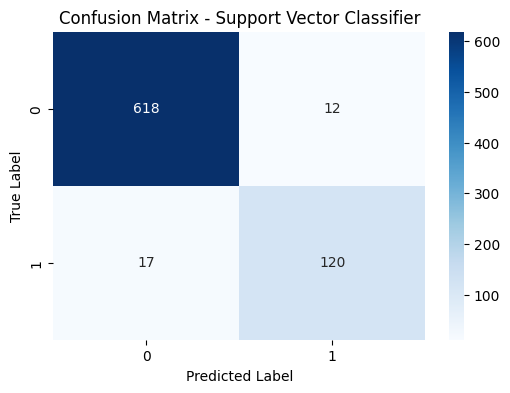

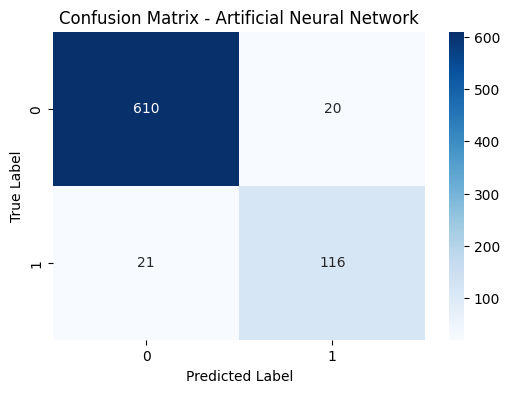

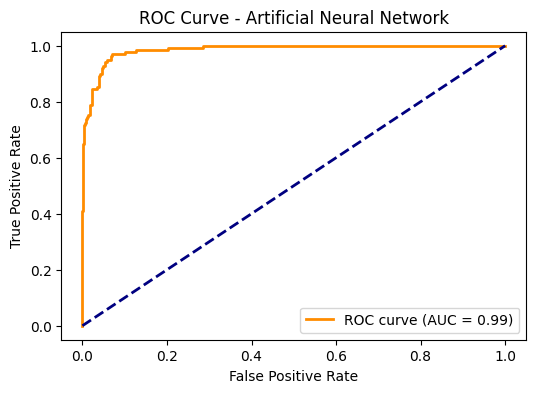

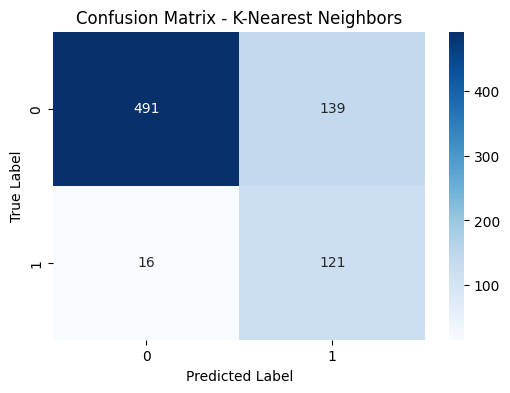

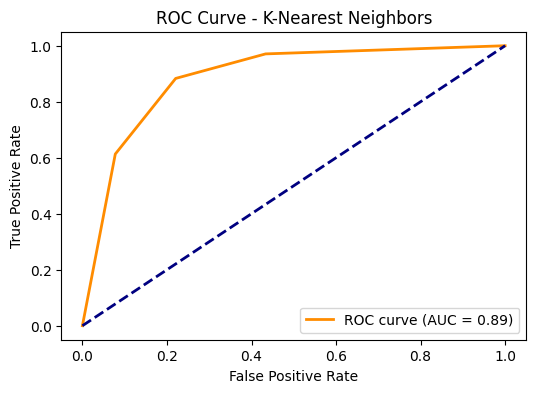

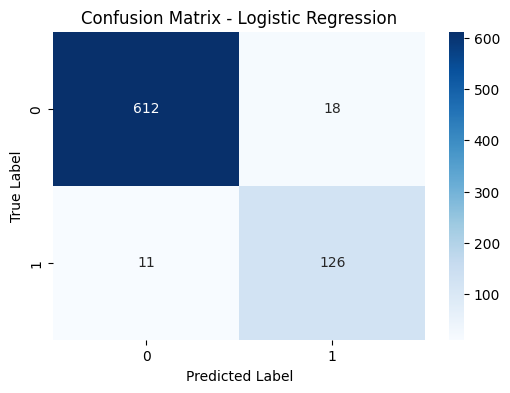

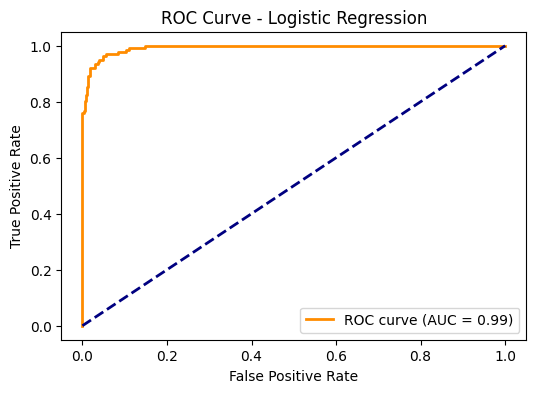

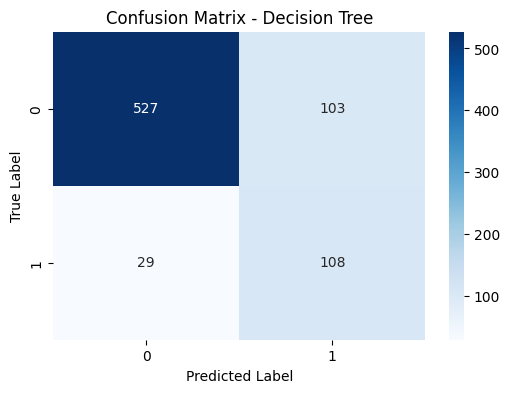

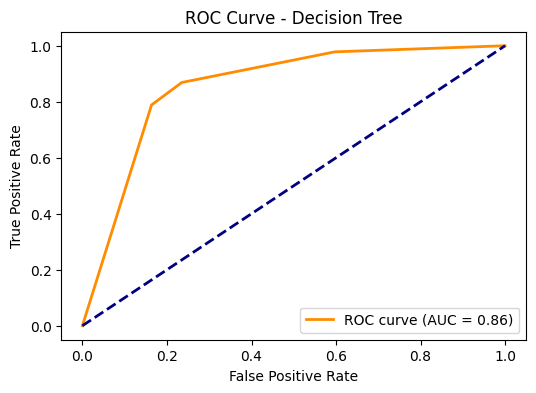

In [82]:
trained_models = train_models(models, X_num_train_bal, Y_num_train_bal)
metrics_df = metrics(trained_models, X_num_test, Y_num_test)

In [83]:
metrics_df

,Support Vector Classifier,Artificial Neural Network,K-Nearest Neighbors,Logistic Regression,Decision Tree
accuracy,0.962190,0.946545,0.797914,0.962190,0.827901
precision,0.961772,0.946397,0.878587,0.963170,0.869965
recall,0.962190,0.946545,0.797914,0.962190,0.827901
f1,0.961914,0.946468,0.818289,0.962556,0.840830
auc,NaN,0.985784,0.886294,0.992851,0.856546


## ***ENSEMBLE METHODS***